# Определение возраста покупателей

## Исследовательский анализ данных

### Импорт библиотек

In [1]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sb

### Загрузка данных


In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale = 1/255)
datagen_flow = datagen.flow_from_dataframe(dataframe = labels,
                                           directory='/datasets/faces/final_files/',
                                           x_col = 'file_name', 
                                           y_col = 'real_age',
                                           target_size = (224, 224),
                                           batch_size = 32,
                                           class_mode = 'raw',
                                           seed = 12345) 

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
display(labels.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


### Исследование данных

#### Размер датасета

In [5]:
labels.shape

(7591, 2)

#### Распределение возраста на фотографиях

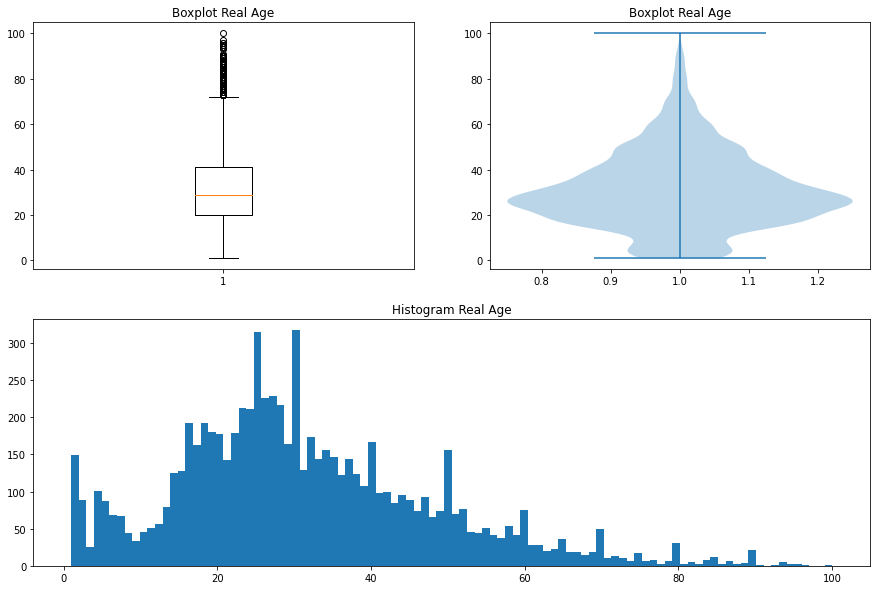

In [6]:
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 1, 2)

ax1.boxplot(labels['real_age'])
ax1.set_title('Boxplot Real Age')

ax2.violinplot(labels['real_age'])
ax2.set_title('Boxplot Real Age')

ax3.hist(labels['real_age'], bins = 100)
ax3.set_title('Histogram Real Age');

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


#### Примеры фотографий из датасета

In [8]:
features, target = next(datagen_flow)

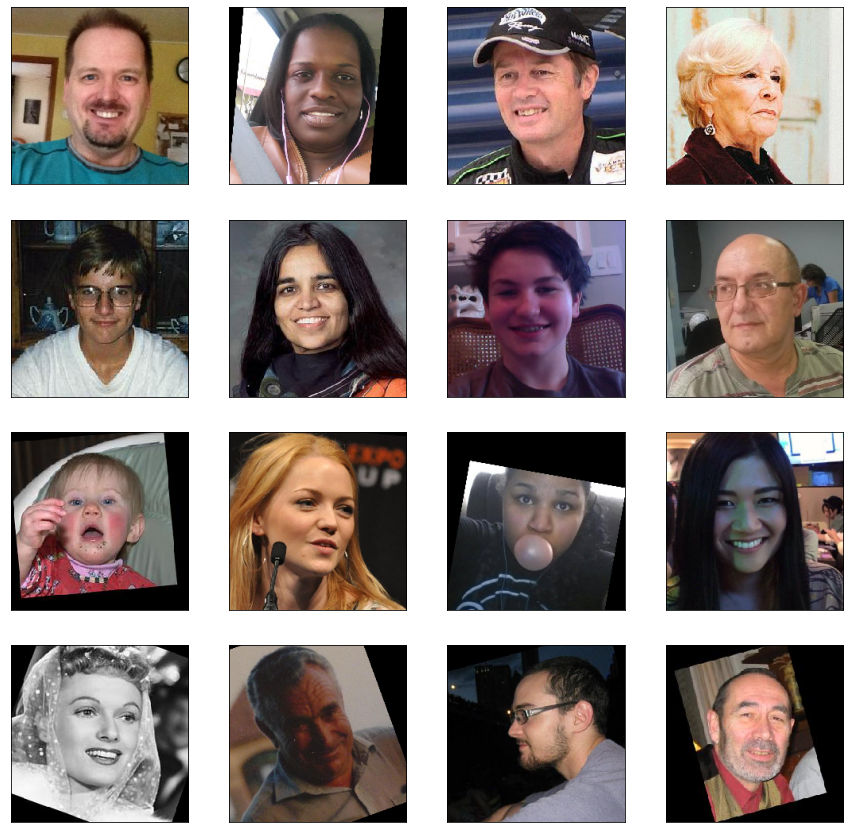

In [9]:
fig = plt.figure(figsize = (15, 15))

for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])

#### Выводы по исследовательскому анализу данных

Датасет состоит из 7591 фотографий людей разных возрастов. Графики распределения возраста выглядят адекватно, аномалий не видно. Средний возраст человека на фото - 31 год. 1й и 3й квантили приходятся на 21 и 40 лет, именна эта возрастная группа наиболее представлена в датасете. Также есть особенность данных, на возрасты около 25, 30, 40, 50, 60, 70, 80 и 90 лет приходится фотографий больше, чем на соседние возрасты. Также много фотографий детей до 10 лет, что в целом не подходит под оба кейса из задания, так как мелкие бытовые сделки (если я верно помню) по закону можно совершать только с 6 лет, поход в магазин в их числе.

В датасете кроме обычных цветных изображений есть черно-белые изображения, а также изображения повернутые под некоторым углом. На фото могут присутствовать объекты, способные помешать распознаванию фото (жвачка, рука, микрофон и тд.). Некоторые фотографии сделаны не анфас.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

### Исходный код модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split = 0.25, horizontal_flip = True, rescale = 1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'training',
        seed = 12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'validation',
        seed = 12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape = input_shape,
        weights = 'imagenet', 
        include_top = False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'relu'))

    optimizer = Adam(lr = 0.0002)
    model.compile(optimizer = optimizer, loss = 'mean_squared_error',
         metrics = ['mae'])


    return model


def train_model(model, train_data, test_data, batch_size = None, epochs = 5,
        steps_per_epoch = None, validation_steps = None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
        validation_data = test_data,
        batch_size = batch_size, 
        epochs = epochs,
        steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps,
        verbose = 2)

    return model

```

### Результаты обучения модели

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 49s - loss: 191.1884 - mae: 10.1760 - val_loss: 324.7726 - val_mae: 13.3868
Epoch 2/5
356/356 - 41s - loss: 95.1043 - mae: 7.4299 - val_loss: 142.5664 - val_mae: 9.0837
Epoch 3/5
356/356 - 40s - loss: 69.8764 - mae: 6.3649 - val_loss: 93.7251 - val_mae: 7.4333
Epoch 4/5
356/356 - 41s - loss: 53.3178 - mae: 5.5809 - val_loss: 87.9038 - val_mae: 7.1012
Epoch 5/5
356/356 - 39s - loss: 43.3710 - mae: 5.0599 - val_loss: 79.2199 - val_mae: 6.6530

119/119 - 9s - loss: 79.2199 - mae: 6.6530
Test MAE: 6.6530

```

## Анализ обученной модели

### Выводы о использованных данных

Изучен датасет состоящий из 7591 фотографий людей разных возрастов. Графики распределения возраста выглядят адекватно, аномалий не видно. Средний возраст человека на фото - 31 год. 1й и 3й квантили приходятся на 21 и 40 лет, именна эта возрастная группа наиболее представлена в датасете. Также есть особенность данных, на возрасты около 25, 30, 40, 50, 60, 70, 80 и 90 лет приходится фотографий больше, чем на соседние возрасты. Также много фотографий детей до 10 лет, что в целом не подходит под оба кейса из задания, так как мелкие бытовые сделки (если я верно помню) по закону можно совершать только с 6 лет, поход в магазин в их числе.

В датасете кроме обычных цветных изображений есть черно-белые изображения, а также изображения повернутые под некоторым углом. На фото могут присутствовать объекты, способные помешать распознаванию фото (жвачка, рука, микрофон и тд.). Некоторые фотографии сделаны не анфас.

### Выводы по обучению нейросети

Была обучена нейросеть состоящая из backbone - ResNet 50, head представляет собой блок GlobalAveragePooling2D и 1 нейрон для решения задачи регрессии. Использованы веса imagenet, batch_size = 16 и оптимизатор Adam. Заморозка весов backbone не применялась. Количество эпох - 5. В качестве функции потерь использована mean squared error. Переобучение не наблюдается, целевая метрика на тестовой выборке даже лучше, чем на обучающей. MAE на тестовой выборке к концу обучения MAE = 6.653.

Получено MAE ниже 8, что удовлетворяет задаче, поставленной перед моделью. Абсолютное отклонение в определении возраста подойдет под кейс применения модели, за исключением контроля продажи алкоголя. Для контроля добросовестности кассира, как мне кажется, вообще не подойдет использование подобного рода подхода к проблеме, так как законность/не законность продажи алкоголя лицу меняется ступенчато и этот момент наступает мгновенно при достижении покупателем совершеннолетия. Даже MAE меньше 1 здесь не даст нужного результата. 

MAE итоговой модели - 6.653.